In [ ]:
# Ignore future warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd ## to read csv as panda dataframe
from collections import Counter ## to count class label

# Scikit learn modules
from sklearn.model_selection import train_test_split ## for spliting dataset into train and test set
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# gensim model for word2vec
from gensim.models.word2vec import Word2Vec

# keras models
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# pad_sequences is used to ensure that all sequences in a list have the same length.
# By default this is done by padding 0 in the beginning of each sequence until each
# sequence has the same length as the longest sequence.

from keras.layers import Embedding, Dropout, LSTM, Dense
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Matplotlib modules for making plot
import matplotlib.pyplot as plt
%matplotlib inline


# Set log
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


# others for utility
import numpy as np
import time


Using TensorFlow backend.


In [ ]:
# DATASET
DATASET_COLUMNS = ["bangla_text", "target"]
DATASET_ENCODING = "utf8"
TRAIN_SIZE = 0.8


# FOR CLEANING DATASET
# DATA CLEAN KORTECHINA APATOTO
# TODO CLEAN DATASET
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"



# WORD 2 VEC
W2V_SIZE = 100 # chnage the value and see the output
W2V_WINDOW = 3 # chnage the value and see the output => Max length of the sentence is __. Try __ as window
W2V_MIN_COUNT = 3 # Try 5 for min_count
W2V_WORKERS = 10
W2V_SG = 1 # 1 if I want skip gram, ) for CBOW
W2V_CBOW = 0
W2V_ITER = 100
W2V_EPOCH = 40 # See Results of each epoch: if accuracy increases then increase number_of_epochs otherwise decrease


# For KERAS
SEQUENCE_LENGTH = 50 # 400 chilo
EPOCHS = 100
BATCH_SIZE = 1024

# SENTIMENT
# SENTIMENT_THRESHOLDS = (0.4, 0.7)
SENTIMENT_THRESHOLDS = (0.0, 0.7)


# Results Based on Word2Vec and Pad Sequence

### 1. When: I'm getting maximum acccuracy
    **For Word2Vec**
    W2V_SIZE = 100
    W2V_WINDOW = 3
    W2V_MIN_COUNT = 3
    W2V_WORKERS = 20
    W2V_SG = 1
    W2V_CBOW = 0
    W2V_ITER = 100
    W2V_EPOCH = 40


    **For KERAS**
    SEQUENCE_LENGTH = 100 # 400 chilo
    EPOCHS = 100
    BATCH_SIZE = 1024

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/My Drive/Thesis/dataset/Our Datasets/CSV/ex_an_hap_Dataset_exc_ang_hap.csv"

In [ ]:

# df = pd.read_csv(directory+file_name, encoding = DATASET_ENCODING, names = DATASET_COLUMNS)

df = pd.read_csv(dataset_path, encoding = DATASET_ENCODING, names = DATASET_COLUMNS)

In [ ]:
df.head(10)

,bangla_text,target
0,সে পড়াশোনা নিয়ে আনন্দিত,excited
1,তার গল্প পত্রিকায় প্রকাশিত হয়েছে,excited
2,সে নিজেকে নিয়ে আনন্দিত,excited
3,শেষ ভালো যার সব ভালো তার,excited
4,সে তার ভুল গুলো নিয়ে ভয় করছে,excited
5,কতদিন পর এত আনন্দ করেছি,excited
6,বহুকাল পর এত আনন্দ করেছি,excited
7,বহুকাল ধরিয়া এত আনন্দ হয় নি আজ যত আনন্দ করেছি,excited
8,প্রতিদিন তার এভাবে পাশে থাকা আমার আনন্দ বাড়িয়ে...,excited
9,সে রেগে বেশিক্ষন চুপ করে থাকেনা,excited


In [ ]:
# df = df.drop(columns=["nan"], axis=1)

In [ ]:
df.head()

,bangla_text,target
0,সে পড়াশোনা নিয়ে আনন্দিত,excited
1,তার গল্প পত্রিকায় প্রকাশিত হয়েছে,excited
2,সে নিজেকে নিয়ে আনন্দিত,excited
3,শেষ ভালো যার সব ভালো তার,excited
4,সে তার ভুল গুলো নিয়ে ভয় করছে,excited


Counter({'excited': 2052, 'angry': 1683, 'happy': 608})


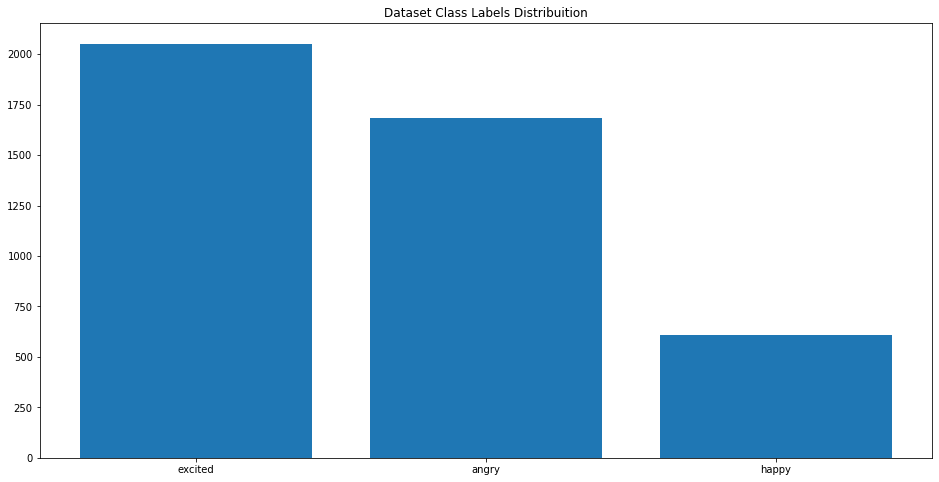

In [ ]:
def dataset_destribution(df):
  target_count = Counter(df.target)
  plt.figure(figsize=(16,8))
  plt.bar(target_count.keys(), target_count.values())
  plt.title("Dataset Class Labels Distribuition")
  print(target_count)
  plt.show()

dataset_destribution(df)

In [ ]:
df_train, df_test = train_test_split(df, test_size= 1-TRAIN_SIZE, random_state = 42, shuffle = True)

print(f"WHOLE DATASET SIZE: {df.shape}\nTRAIN SIZE: {len(df_train)}\nTEST SIZE: {len(df_test)}")

WHOLE DATASET SIZE: (4343, 2)
TRAIN SIZE: 3474
TEST SIZE: 869


Counter({'excited': 1618, 'angry': 1366, 'happy': 490})


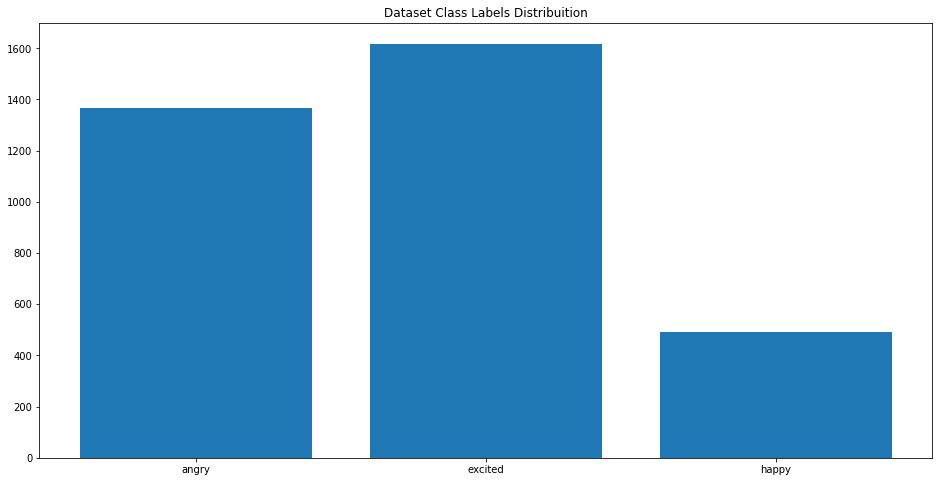

In [ ]:
dataset_destribution(df_train)

Counter({'excited': 434, 'angry': 317, 'happy': 118})


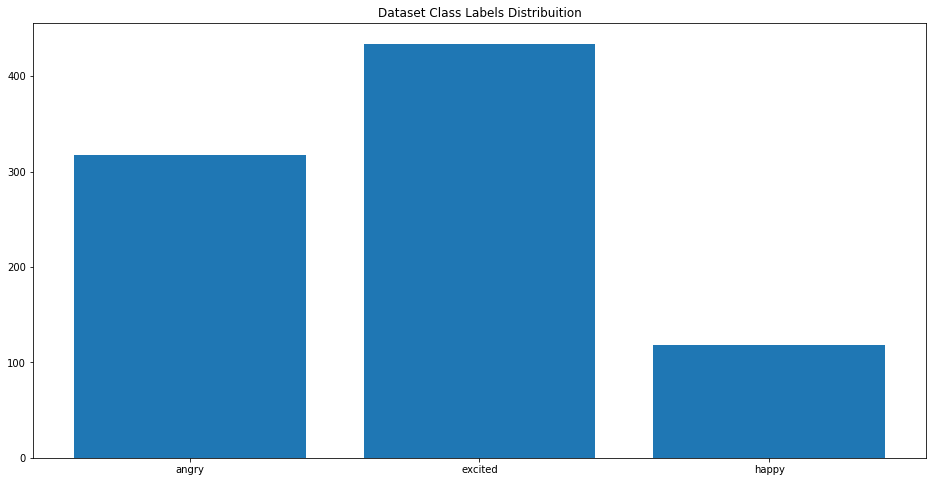

In [ ]:
dataset_destribution(df_test)

In [ ]:
%%time

# splitting each word in train_set
# documents = [_bangla_text.split() for _bangla_text in df_train.bangla_text] # shudhu train er upor na kore pura dataset er upor documnet banay dekhte hobe
documents_sg = [_bangla_text.split() for _bangla_text in df.bangla_text]
print(type(documents_sg))

<class 'list'>
CPU times: user 4.49 ms, sys: 62 µs, total: 4.55 ms
Wall time: 5.04 ms


In [ ]:
%%time
w2v_model_sg = Word2Vec(size=W2V_SIZE,
                              window=W2V_WINDOW,
                              min_count=W2V_MIN_COUNT,
                              workers=W2V_WORKERS,
                              sg=W2V_SG,
                              iter=W2V_ITER)

CPU times: user 580 µs, sys: 0 ns, total: 580 µs
Wall time: 548 µs


In [ ]:
w2v_model_sg.build_vocab(documents_sg) # skip gram

2020-02-27 10:59:19,669 : INFO : collecting all words and their counts
2020-02-27 10:59:19,671 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-02-27 10:59:19,682 : INFO : collected 3703 word types from a corpus of 20104 raw words and 4343 sentences
2020-02-27 10:59:19,683 : INFO : Loading a fresh vocabulary
2020-02-27 10:59:19,690 : INFO : effective_min_count=3 retains 1333 unique words (35% of original 3703, drops 2370)
2020-02-27 10:59:19,691 : INFO : effective_min_count=3 leaves 17180 word corpus (85% of original 20104, drops 2924)
2020-02-27 10:59:19,706 : INFO : deleting the raw counts dictionary of 3703 items
2020-02-27 10:59:19,707 : INFO : sample=0.001 downsamples 60 most-common words
2020-02-27 10:59:19,708 : INFO : downsampling leaves estimated 13928 word corpus (81.1% of prior 17180)
2020-02-27 10:59:19,713 : INFO : estimated required memory for 1333 words and 100 dimensions: 1732900 bytes
2020-02-27 10:59:19,714 : INFO : resetting layer weigh

In [ ]:
words_sg = w2v_model_sg.wv.vocab.keys()


vocab_size_sg = len(words_sg)
print("Skip Gram Vocabulary Size: ", vocab_size_sg)


Skip Gram Vocabulary Size:  1333


In [ ]:
w2v_model_sg.wv['আগুন'] # will show the word "মেয়েটি" represented by W2V_SIZE weights

array([ 3.8705855e-03, -5.8608491e-04, -1.7608188e-03, -2.5680175e-03,
        3.5757748e-03,  3.7984208e-03, -2.9038587e-03, -6.3146703e-04,
       -2.3998271e-03, -2.2932976e-03,  4.1945549e-03,  1.6165127e-03,
       -3.1781017e-03, -3.8239306e-03,  7.2320743e-04,  9.9928235e-05,
       -3.8832061e-03,  1.2738799e-03, -4.6803276e-03, -1.4403249e-03,
       -4.4505595e-04, -4.8085265e-03, -2.5115830e-03,  3.6779300e-05,
        3.2611382e-03, -6.2166218e-04,  3.5460643e-03, -2.5409120e-03,
        4.8876442e-03, -1.4942045e-03,  1.9487147e-03, -3.8692097e-03,
       -4.1433843e-03,  1.7641123e-03, -1.2965292e-03,  4.8196130e-03,
        7.2788459e-04, -1.2403808e-03, -3.8008275e-05,  3.7925076e-03,
        2.5212714e-03,  1.8435520e-03,  2.1888316e-03,  4.2090015e-03,
        4.2458116e-03, -1.4639074e-03,  2.1600223e-04, -3.4938217e-03,
       -3.0741380e-03, -9.2612114e-04, -9.5244910e-04, -3.4125142e-03,
        2.6188232e-03, -9.1728216e-06, -1.1218534e-03,  4.7362973e-03,
      

In [ ]:
w2v_model_sg.wv.most_similar("আগুন") # most similar before making w2vec

2020-02-27 10:59:19,992 : INFO : precomputing L2-norms of word weight vectors


[('নরম', 0.29907625913619995),
 ('বাতাস', 0.2918718755245209),
 ('বিষয়', 0.29056617617607117),
 ('প্রতি', 0.28956934809684753),
 ('গোপন', 0.2695940136909485),
 ('অন্যদের', 0.2562375068664551),
 ('মানিয়েছে', 0.25505203008651733),
 ('পরচর্চা', 0.2431846559047699),
 ('কালনাগ', 0.24138286709785461),
 ('রাগের', 0.2396630346775055)]

In [ ]:
%%time
w2v_model_sg.train(documents_sg, total_examples=len(documents_sg), epochs=W2V_EPOCH)

2020-02-27 10:59:20,010 : INFO : training model with 10 workers on 1333 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=3
2020-02-27 10:59:20,073 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-02-27 10:59:20,075 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-02-27 10:59:20,076 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-02-27 10:59:20,077 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-02-27 10:59:20,078 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-02-27 10:59:20,079 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-27 10:59:20,080 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-27 10:59:20,082 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-27 10:59:20,102 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-27 10:59:20,122 : INFO 

CPU times: user 2.38 s, sys: 182 ms, total: 2.56 s
Wall time: 2.37 s


(557452, 804160)

In [ ]:
try:
    most_similar = w2v_model_sg.most_similar("আগুন")

except KeyError as e:
    print(e)

most_similar

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
2020-02-27 10:59:22,397 : INFO : precomputing L2-norms of word weight vectors


[('জ্বলবে', 0.9107077121734619),
 ('একা', 0.8898437023162842),
 ('জ্বলে', 0.8822411298751831),
 ('ঘরে', 0.8399821519851685),
 ('আরাম', 0.8331995606422424),
 ('চেয়ারে', 0.8306315541267395),
 ('ভালবাসতে', 0.827613115310669),
 ('ভেঙেছে', 0.8205465078353882),
 ('বিদেশে', 0.8195927739143372),
 ('কঠোর', 0.8185871839523315)]

In [ ]:
w2v_model_sg.wv.doesnt_match("সে কি আমার প্রতি আশাহত হয়েছে".split())

2020-02-27 10:59:22,416 : WARNING : vectors for words {'আশাহত'} are not present in the model, ignoring these words


'কি'

In [ ]:
# w2v_model_sg.wv.save("/content/drive/My Drive/Thesis/dataset/w2vec_model/word2vecModel_300_2-sentiment_7460_sg.model")

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.bangla_text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words in vocabulary: ", vocab_size)

Total words in vocabulary:  3305
CPU times: user 78.5 ms, sys: 52.6 ms, total: 131 ms
Wall time: 103 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.bangla_text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.bangla_text), maxlen=SEQUENCE_LENGTH)

CPU times: user 66.8 ms, sys: 1.07 ms, total: 67.9 ms
Wall time: 68.6 ms


In [ ]:
labels = df_train.target.unique().tolist()
labels

['angry', 'excited', 'happy']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (3474, 1)
y_test (869, 1)


In [ ]:
print(f"y_train: \n{y_train[:15]} \n\ny_test: \n{y_test[:15]}")

y_train: 
[[0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [2]
 [2]
 [1]
 [0]
 [0]
 [1]] 

y_test: 
[[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [2]
 [0]
 [2]
 [2]
 [1]
 [0]]


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (3474, 50)
y_train (3474, 1)

x_test (869, 50)
y_test (869, 1)


In [ ]:
# embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
embedding_matrix_sg = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model_sg.wv:
        embedding_matrix_sg[i] = w2v_model_sg.wv[word]
print(embedding_matrix_sg.shape)

(3305, 100)


In [ ]:
embedding_layer_sg = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix_sg], input_length=SEQUENCE_LENGTH, trainable=False)

2020-02-27 10:59:22,707 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [ ]:
embedding_layer_sg.trainable

False

In [ ]:
model_sg = Sequential()
model_sg.add(embedding_layer_sg)
model_sg.add(Dropout(0.5))
model_sg.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_sg.add(Dense(1, activation='sigmoid'))

model_sg.summary()

2020-02-27 10:59:22,732 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2020-02-27 10:59:22,744 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2020-02-27 10:59:22,759 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2020-02-27 10:59:22,762 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2020-02-27 10:59:22,764 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2020-02-27 10:59:24,232 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2020-02-27 10:59:24,237 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:216: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



2020-02-27 10:59:24,321 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2020-02-27 10:59:30,887 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2020-02-27 10:59:30,901 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           330500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 411,001
Trainable params: 80,501
Non-trainable params: 330,500
_________________________________________________________________


In [ ]:
model_sg.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

2020-02-27 10:59:31,258 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



2020-02-27 10:59:31,282 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-02-27 10:59:31,289 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history_sg = model_sg.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs= 20,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2020-02-27 10:59:32,107 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



2020-02-27 10:59:32,287 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 3126 samples, validate on 348 samples
Epoch 1/20
3126/3126 [==============================] - 3s 925us/step - loss: 0.6604 - acc: 0.4415 - val_loss: 0.5974 - val_acc: 0.4684
Epoch 2/20
3126/3126 [==============================] - 0s 155us/step - loss: 0.5944 - acc: 0.4655 - val_loss: 0.5455 - val_acc: 0.4684
Epoch 3/20
3126/3126 [==============================] - 0s 146us/step - loss: 0.5527 - acc: 0.4655 - val_loss: 0.5154 - val_acc: 0.4684
Epoch 4/20
3126/3126 [==============================] - 0s 125us/step - loss: 0.5262 - acc: 0.4655 - val_loss: 0.4855 - val_acc: 0.4684
Epoch 5/20
3126/3126 [==============================] - 0s 149us/step - loss: 0.4927 - acc: 0.4658 - val_loss: 0.4420 - val_acc: 0.4684
Epoch 6/20
3126/3126 [==============================] - 0s 138us/step - loss: 0.4597 - acc: 0.4779 - val_loss: 0.3990 - val_acc: 0.5086
Epoch 7/20
3126/3126 [==============================] - 0s 132us/step - loss: 0.4270 - acc: 0.5048 - val_loss: 0.3485 - val_acc: 0.5460
E

In [ ]:
%%time
score_sg = model_sg.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("\nSkip Gram Accuracy")
print(f"ACCURACY: {score_sg[1]}    ==> {score_sg[1] * 100 : 0.2f}%")
print(f"LOSS: {score_sg[0]}    ==> {score_sg[0] * 100 : 0.2f}% \n")

869/869 [==============================] - 0s 67us/step

Skip Gram Accuracy
ACCURACY: 0.6329113841056824    ==>  63.29%
LOSS: -0.058266133069992065    ==> -5.83% 

CPU times: user 64.8 ms, sys: 13.7 ms, total: 78.4 ms
Wall time: 60.8 ms


In [ ]:
x_test

array([[   0,    0,    0, ...,  128,  134,    9],
       [   0,    0,    0, ...,    6, 1606,  169],
       [   0,    0,    0, ...,  384,  561,  932],
       ...,
       [   0,    0,    0, ...,   42,  913,    6],
       [   0,    0,    0, ...,  728, 1483,    4],
       [   0,    0,    0, ...,    5,   47,  547]], dtype=int32)

In [ ]:
df.shape

(4343, 2)

In [ ]:
def plot_validation_accuraccy(history_sg):
  # Plot training & validation accuracy values
  plt.plot(history_sg.history['acc'])
  plt.plot(history_sg.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

def plot_validation_loss(history_sg):
  # Plot training & validation loss values
  plt.plot(history_sg.history['loss'])
  plt.plot(history_sg.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()


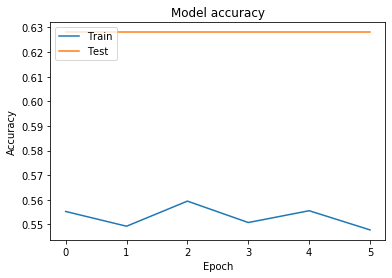

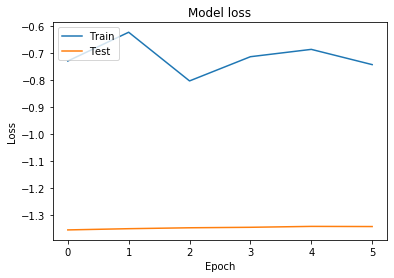

In [ ]:
plot_validation_accuraccy(history_sg)
plot_validation_loss(history_sg)

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = "NEUTRAL"
    if score <= SENTIMENT_THRESHOLDS[0]:
        label = "negative"
    elif score >= SENTIMENT_THRESHOLDS[1]:
        label = "positive"

        return label
    else:
        return "negative" if score < 0.5 else "positive"

In [ ]:
def predict_sg(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)


    # print(f"x_test = {x_test}: Size: {len(x_test[0])}, Sequence Length: {SEQUENCE_LENGTH}")


    # Predict
    score = model_sg.predict([x_test])[0]
    # print(f"Score is: {score}")

    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
def predict_sg(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)


    # print(f"x_test = {x_test}: Size: {len(x_test[0])}, Sequence Length: {SEQUENCE_LENGTH}")


    # Predict
    score = model_sg.predict([x_test])[0]
    # print(f"Score is: {score}")

    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
new_class_label = []
count = 1
for word in df_test['bangla_text']:
  prediction = predict_sg(word)
  new_class_label.append(prediction['label'])
  # print(f"{count}  {word}   == {prediction['label']}")
  count += 1


len(new_class_label)

len(df_test['target'])

count = 0
wrong_res_count = 0
for index, row in df_test.iterrows():
  if(row['target'] != new_class_label[count]):
    print(f"{index}  {row['bangla_text']}  A: {row['target']}  G: {new_class_label[count]}")
    wrong_res_count += 1

  count += 1

print(f"Total wrong result given: {wrong_res_count}")

1978  কোনটা ভাল কোনটা খারাপ জানি আমি  A: positive  G: negative
7271  আমি থাকতে তোমাদের সাথে কিভাবে খারাপ কিছু ঘটে যেতো  A: positive  G: negative
576  তোমার চোখে পানি দেখতে চাইনা  A: positive  G: negative
965  সে পাশে নেই আমাদের  A: negative  G: positive
101  ভালবাসা সুন্দর কিন্তু কখনো কষ্টের  A: negative  G: positive
2579  তুমি শান্তি মত বসো আগে  A: positive  G: negative
1765  সবকিছু দিয়েছ কিছু বাকি রাখো নাই  A: positive  G: negative
1562  আমাদের মাঝে কেউ কখনও আসবেনা  A: positive  G: negative
3381  সে কবি রূপে অসাধারণ মানুষ  A: positive  G: negative
2063  আমার কাছে তোমার কোনো সংকোচ নেই  A: positive  G: negative
706  সে সবার জীবনে খুশি নিয়ে এসেছে  A: positive  G: negative
3611  তার কোনো বাজে স্বভাব নেই  A: positive  G: negative
1656  সে আমাকে কখনও অমান্য করেনা  A: positive  G: negative
1795  সে আমার কথা রাখল  A: positive  G: negative
6627  আমি অসুস্থ হয়ে অনেক দূর্বল হয়ে গেছি  A: negative  G: positive
132  আমি সব কিছু দেখিনা  A: negative  G: positive
3386  সে দরিদ্র কিন্তু তার ব্যবহার সু

In [ ]:
def plot_confusion_matrix(cm, labels, normalize = False, title = "Confusion Matrix", cmap = plt.cm.Blues):
  """
  This function prints and plots the confusion matrix
  Normalization can be applied by setting 'normalize=True'
  """

  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation = 0)
  plt.yticks(tick_marks, labels)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis==1)[:, np.netwaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix, Without Normalization")

  print(cm)

  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment = "center",
             color = "white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

Confusion Matrix, Without Normalization
[[600 153]
 [134 604]]


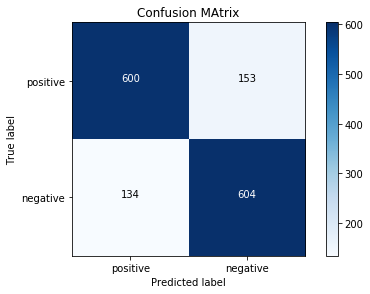

In [ ]:
cm = confusion_matrix(df_test['target'], new_class_label, labels=["positive", "negative"])
cm_plot_labels = ["positive", "negative"]

plot_confusion_matrix(cm, cm_plot_labels, title="Confusion MAtrix")

In [ ]:
detail_classification_report = classification_report(df_test['target'], new_class_label)
print(detail_classification_report)

              precision    recall  f1-score   support

    negative       0.80      0.82      0.81       738
    positive       0.82      0.80      0.81       753

    accuracy                           0.81      1491
   macro avg       0.81      0.81      0.81      1491
weighted avg       0.81      0.81      0.81      1491



In [ ]:
predict_sg("অমিত স্যার আমাদের উপর রাগ করেছেন")

{'elapsed_time': 0.24304676055908203,
 'label': 'negative',
 'score': 0.3085589110851288}

In [ ]:
predict_sg("সে খুব নিষ্পাপ মানুষ তাই তাকে এত ভালোবাসি")

{'elapsed_time': 0.24842309951782227,
 'label': 'positive',
 'score': 0.974915087223053}

In [ ]:
predict_sg("আমি তাকে সব বলি সবসময়")

{'elapsed_time': 0.23162150382995605,
 'label': 'positive',
 'score': 0.7172318696975708}

In [ ]:
predict_sg("তিনি কাজ করতে চান না")

{'elapsed_time': 0.2643318176269531,
 'label': 'negative',
 'score': 0.4085671007633209}

In [ ]:
predict_sg("তিনি কাজ করতে চান")

{'elapsed_time': 0.2763974666595459,
 'label': 'positive',
 'score': 0.5249828100204468}

In [ ]:
predict_sg("সবাই তাকে ভাল পায় না")

{'elapsed_time': 0.25525856018066406,
 'label': 'positive',
 'score': 0.5180718898773193}

In [ ]:
predict_sg("সে খারাপ ছেলে")

{'elapsed_time': 0.2723567485809326,
 'label': 'negative',
 'score': 0.31728923320770264}

In [ ]:
predict_sg("ভালো")

{'elapsed_time': 0.2474818229675293,
 'label': 'positive',
 'score': 0.7358874082565308}

In [ ]:
predict_sg("না")

{'elapsed_time': 0.27509284019470215,
 'label': 'negative',
 'score': 0.43521648645401}

In [ ]:
predict_sg("সে ভালো না")

{'elapsed_time': 0.23845601081848145,
 'label': 'positive',
 'score': 0.6685115098953247}

In [ ]:
predict_sg("সে আমাকে খুব পছন্দ করে")

{'elapsed_time': 0.28400492668151855,
 'label': 'positive',
 'score': 0.5876883864402771}

In [ ]:
predict_sg("তিনি তাকে চান")

{'elapsed_time': 0.26579809188842773,
 'label': 'positive',
 'score': 0.5873098969459534}

Precision
Precision attempts to answer the following question:

What proportion of positive identifications was actually correct?

